# Project 1
## Sky Cen

Notebook file can be found at: https://github.com/censky2/CS666/tree/main/proj1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

Store training and test data

In [2]:
training_file = "textA.txt"
test_file = "textB.txt"

def store_data(file_name):
    f = open(file_name, "r")
    text = f.read()
    data = [26 if ord(c) == 32 else ord(c) - 97 for c in list(text)]
    return data

train = np.array(store_data(training_file)[:-1])
test = np.array(store_data(test_file)[:-1])


## **(1A)** **(2A)**
Initialize transition and emission probability matrices

In [3]:
def init_hmm(num_states):
    if num_states == 2:
        A = np.array([[0.49, 0.51], 
                    [0.51, 0.49]])
        B = np.zeros((27, 2, 2))
        B[0:13] = np.array([[0.0370, 0.0371],
                        [0.0370, 0.0371]])
        B[13:26] = np.array([[0.0371, 0.0370],
                            [0.0371, 0.0370]])
        B[26] = np.array([[0.0367, 0.0367],
                        [0.0367, 0.0367]])
    elif num_states == 4:
        A = np.array([[0.24, 0.26, 0.24, 0.26],
                      [0.26, 0.24, 0.26, 0.24],
                      [0.24, 0.24, 0.26, 0.26],
                      [0.26, 0.26, 0.24, 0.24]])
        B = np.zeros((27, 4, 4))
        B[0:13] = np.array([[0.0370, 0.0371, 0.0370, 0.0371],
                            [0.0370, 0.0371, 0.0370, 0.0371],
                            [0.0370, 0.0371, 0.0370, 0.0371],
                            [0.0370, 0.0371, 0.0370, 0.0371]])
        B[13:26] = np.array([[0.0371, 0.0370, 0.0371, 0.0370],
                            [0.0371, 0.0370, 0.0371, 0.0370],
                            [0.0371, 0.0370, 0.0371, 0.0370],
                            [0.0371, 0.0370, 0.0371, 0.0370]])
        B[26] = np.array([[0.0367, 0.0367, 0.0367, 0.0367],
                        [0.0367, 0.0367, 0.0367, 0.0367],
                        [0.0367, 0.0367, 0.0367, 0.0367],
                        [0.0367, 0.0367, 0.0367, 0.0367]])
    return A, B

If the 2 state HMM was initialized symmetrically where the probabilites were set to uniform, the model would be less efficient at learning. This is because the two states emission and transition probabilities will be the same. So, the model parameters will remain symmetric. With both states behaving identically, the 2 state HMM will essentially learn as effectively as a simple 1 HMM model.

Define forward and backward algorithm

In [4]:
def forward(A, B, alpha_0, data):
    alphas = np.zeros((len(data) + 1, len(alpha_0)))
    alphas[0] = alpha_0

    qs = np.zeros((len(data) + 1))
    qs[0] = 1

    for i in range(len(data)):
        alphas[i + 1] = (np.multiply(A, B[data[i]]).T) @ alphas[i]
        qs[i + 1] = np.sum(alphas[i + 1])
        alphas[i + 1] = alphas[i + 1] / qs[i + 1]

    return alphas, qs


def backward(A, B, data, qs):
    beta_n = np.ones(A.shape[0])
    betas = np.zeros((len(data) + 1, len(beta_n)))
    betas[-1] = beta_n

    for i in range(len(data) - 1, -1, -1):
        betas[i] = ((np.multiply(A, B[data[i]])) @ betas[i + 1]) / qs[i]

    return betas


def unnormalize_alphas(alphas, qs):
    assert alphas.shape[0] == len(qs)

    unnormalized_probs = np.zeros_like(alphas)

    prod_qs = 1
    for i in range(len(qs)):
        prod_qs *= qs[i]
        unnormalized_probs[i] = alphas[i] * prod_qs
    
    return unnormalized_probs


def unnormalize_betas(betas, qs):
    assert betas.shape[0] == len(qs)

    unnormalized_probs = np.zeros_like(betas)
    unnormalized_probs[-1] = betas[-1]

    prod_qs = 1

    for i in range(len(qs) - 2, -1, -1):
        prod_qs *= qs[i]
        unnormalized_probs[i] = betas[i] * prod_qs
    
    return unnormalized_probs

# # test
# A = np.array([[1/2, 1/6, 1/6], [0, 0, 1/3], [3/4, 1/4, 0]])
# B = np.array([[[1, 1/2, 1], [0, 0, 1/3], [0, 0, 0]], [[0, 1/2, 0], [0, 0, 2/3], [1, 1, 0]]])
# alphas, qs = forward(A, B, np.array([1, 0, 0]), [0, 1, 1, 0])
# betas = backward(A, B, [0, 1, 1, 0], qs)

# print(alphas)
# print(betas)

# u_alphas = unnormalize_alphas(alphas, qs)
# u_betas = unnormalize_betas(betas, qs)
# marginal = np.sum(u_alphas[-1])

# print(marginal)

# assert np.isclose(np.prod(qs), marginal)
# assert np.isclose(u_betas[0][0], marginal)

# for i in range(len(alphas)):
#     assert np.isclose(np.sum(u_alphas[i] * u_betas[i]), marginal)

Define Baum-Welch algorithm

In [ ]:
def baum_welch(A, B, train_data, test_data, letters, iterations):
    
    train_log_probs = []
    test_log_probs = []
    letters_emission = {}

    for letter in letters:
        letters_emission[letter] = np.zeros((iterations, B.shape[1], B.shape[2]))

    for x in tqdm(range(iterations)):
        alpha_0 = np.array(A.shape[0] * [1 / A.shape[0]])
        alphas, qs = forward(A, B, alpha_0, train_data)
        betas = backward(A, B, train_data, qs)

        _, test_qs = forward(A, B, alpha_0, test_data)

        soft_counts = np.zeros((A.shape[0], A.shape[1], B.shape[0]))

        # Store emission probs for certain letters
        for key in letters_emission.keys():
            letters_emission[key][x] = B[key]

        # Accumulate soft counts
        for i in range(len(train_data)):
            trans_emiss = np.multiply(A, B[train_data[i]])
            
            for j in range(trans_emiss.shape[0]):
                for k in range(trans_emiss.shape[1]):
                    soft_counts[j][k][train_data[i]] += alphas[i][j] * trans_emiss[j][k] * betas[i + 1][k]
        
        c_mn = np.sum(soft_counts, axis=2, keepdims=True)

        # for i in range(soft_counts.shape[0]):
        #     for j in range(soft_counts.shape[1]):
        #         for k in range(soft_counts.shape[2]):
        #             if soft_counts[i][j][k] == 0 or c_mn[i][j] == 0:
        #                 B[k][i][j] = 0
        #             else:
        #                 B[k][i][j] = soft_counts[i][j][k] / c_mn[i][j]

        B = np.where(c_mn == 0, 0, soft_counts / c_mn)
        B = np.transpose(B, (2, 0, 1))
        
        c_m = np.sum(c_mn, axis=1, keepdims=True)

        # for i in range(c_mn.shape[0]):
        #     for j in range(c_mn.shape[1]):
        #         if c_mn[i][j] == 0 or c_m[i] == 0:
        #             A[i][j] = 0
        #         else:
        #             A[i][j] = c_mn[i][j] / c_m[i]
        
        A = np.where(c_m == 0, 0, c_mn / c_m)
        A = np.squeeze(A)

        # Calculate average log-probs
        train_log_prob = np.sum(np.log(qs))
        train_log_probs.append(train_log_prob / len(train_data))

        test_log_prob = np.sum(np.log(test_qs))
        test_log_probs.append(test_log_prob / len(test_data))
    
    return A, B, train_log_probs, test_log_probs, letters_emission

# # test
# A = np.array([[1/2, 1/6, 1/6], [0, 0, 1/3], [3/4, 1/4, 0]])
# B = np.array([[[1, 1/2, 1], [0, 0, 1/3], [0, 0, 0]], [[0, 1/2, 0], [0, 0, 2/3], [1, 1, 0]]])

# baum_welch(A, B, [0, 1, 1, 0], 1)

Train for 2 State HMM 600 Tterations

In [6]:
A, B = init_hmm(2)
letters = [0, 1, 2, 13, 14, 15, 26]
A, B, train_log_probs, test_log_probs, letters_emission = baum_welch(A, B, train, test, letters, 600)
assert all(x <= y for x, y in zip(train_log_probs, train_log_probs[1:]))

100%|██████████| 600/600 [02:53<00:00,  3.46it/s]


## **(1B)**
Plot average log-probabilities of train and test data

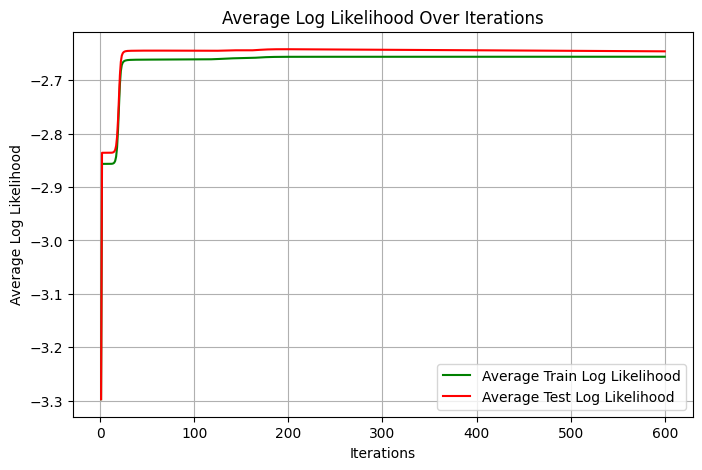

In [7]:
plt.figure(figsize=(8, 5))
iterations = range(1, len(train_log_probs) + 1)
plt.plot(iterations, train_log_probs, linestyle='-', label="Average Train Log Likelihood", color='green')
plt.plot(iterations, test_log_probs, linestyle='-', label="Average Test Log Likelihood", color='red')

plt.xlabel("Iterations")
plt.ylabel("Average Log Likelihood")
plt.title("Average Log Likelihood Over Iterations")
plt.legend()
plt.grid(True)

plt.show()

In [8]:
print(f"Final Train Log-Probability: {train_log_probs[-1]}")
print(f"Final Test Log-Probability: {test_log_probs[-1]}")

Final Train Log-Probability: -2.6563159566542938
Final Test Log-Probability: -2.6462074084741056


## **(1C)**
Plot emission probabilities of a few particular letters

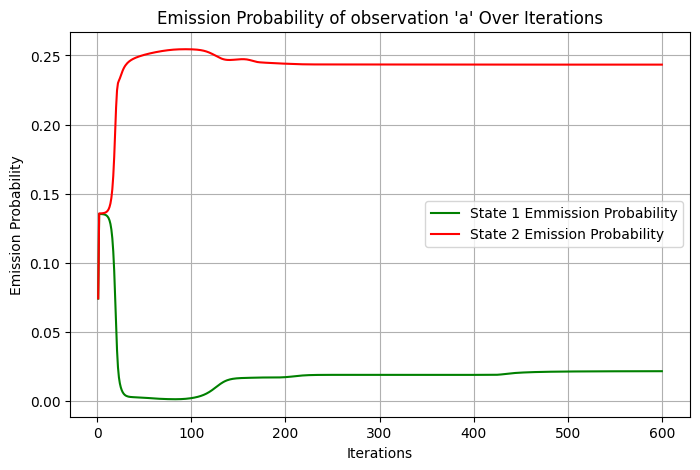

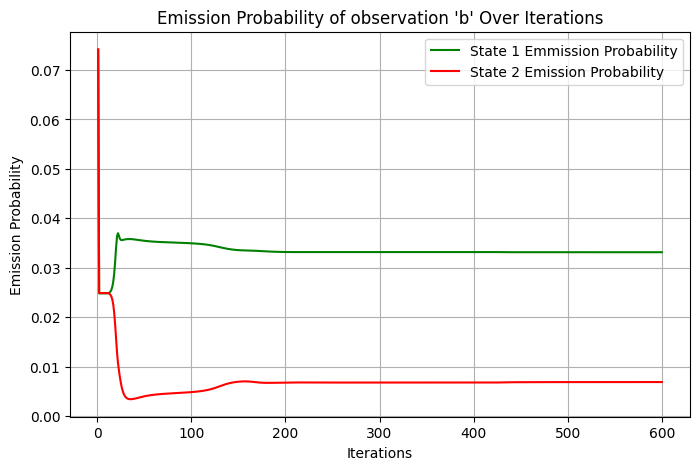

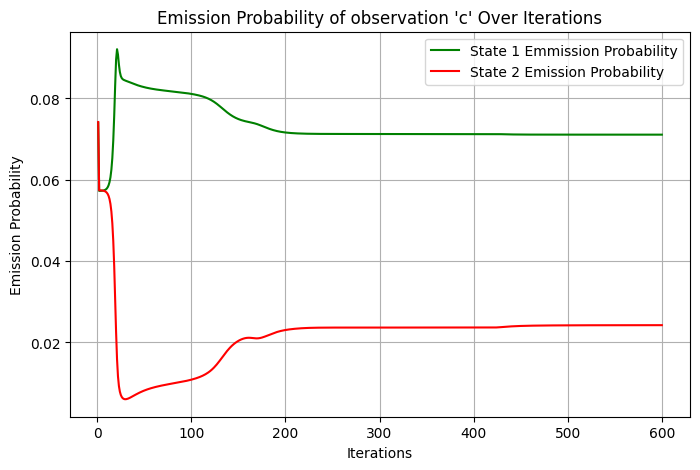

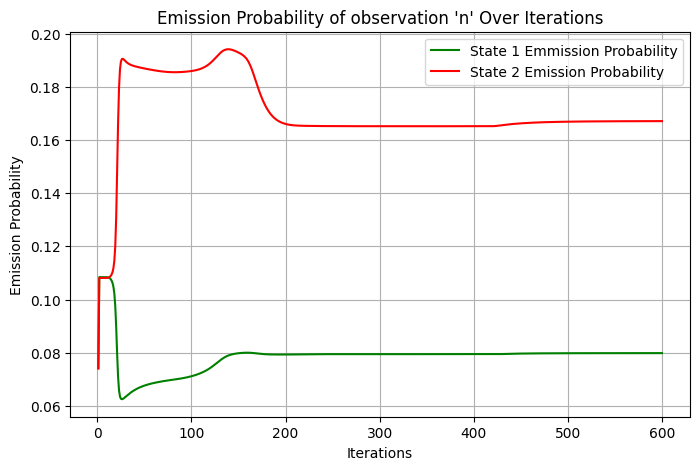

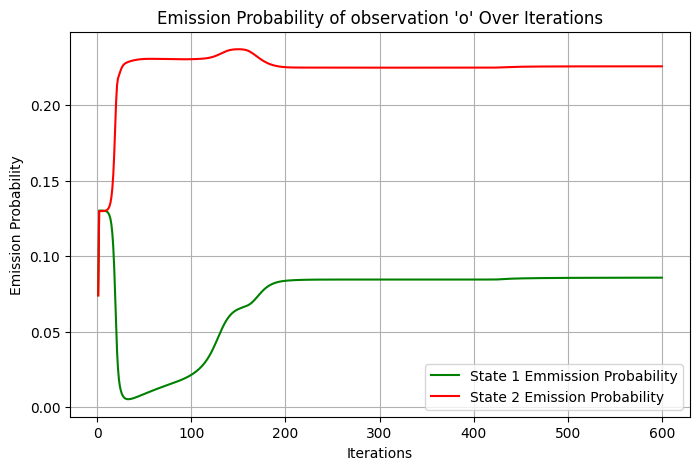

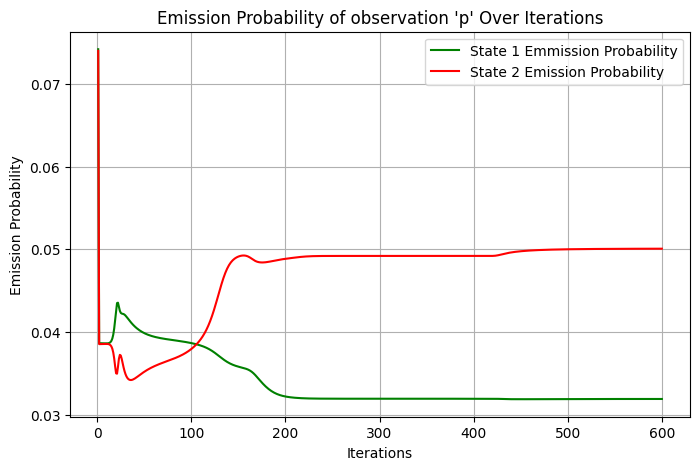

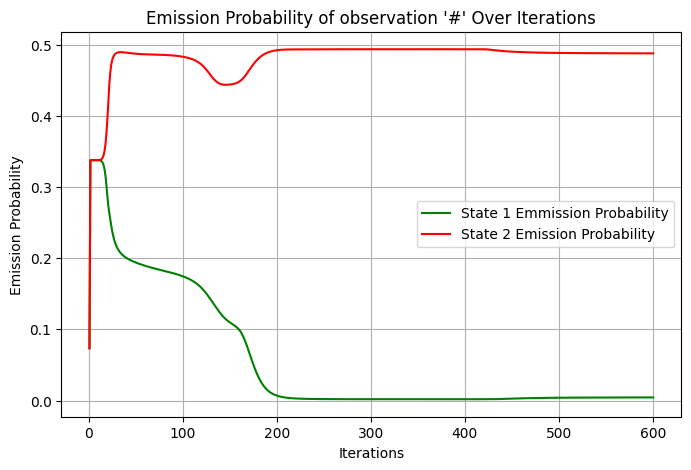

In [9]:
for k, v in letters_emission.items():
    plt.figure(figsize=(8, 5))

    iterations = range(1, len(v) + 1)
    temp = np.sum(v, axis=1)
    emission1 = np.reshape(temp[:, 0], -1)
    emission2 = np.reshape(temp[:, 1], -1)
    
    letter = 35 if k == 26 else k + 97
    plt.xlabel("Iterations")
    plt.ylabel("Emission Probability")
    plt.title(f"Emission Probability of observation \'{chr(letter)}\' Over Iterations")
    plt.plot(iterations, emission1, linestyle='-', label="State 1 Emmission Probability", color='green')
    plt.plot(iterations, emission2, linestyle='-', label="State 2 Emission Probability", color='red')
    plt.legend()
    plt.grid(True)
    plt.show()


## **(1D)**
Plot and analyze emission probability distributions of each state

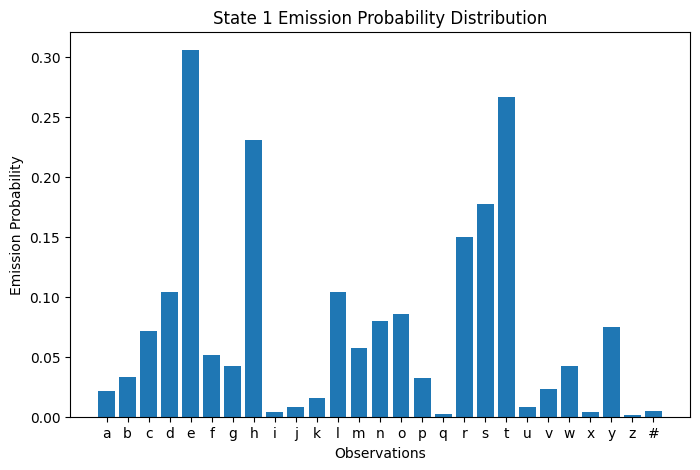

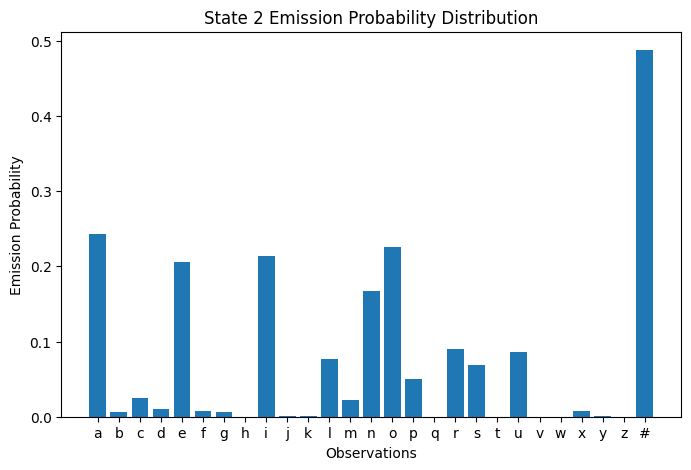

In [10]:
temp = np.sum(B, axis=1)

emission1 = np.reshape(temp[:, 0], -1)
emission2 = np.reshape(temp[:, 1], -1)
vocab = [chr(35) if k == 26 else chr(k + 97) for k in range(len(emission1))]

plt.figure(figsize=(8, 5))
plt.bar(vocab, emission1)
plt.xlabel("Observations")
plt.ylabel("Emission Probability")
plt.title("State 1 Emission Probability Distribution")
plt.show()

plt.figure(figsize=(8, 5))
plt.bar(vocab, emission2)
plt.xlabel("Observations")
plt.ylabel("Emission Probability")
plt.title("State 2 Emission Probability Distribution")
plt.show()



Analyze Updated Transition Matrix

In [11]:
print(A)

[[0.29394323 0.70605677]
 [0.67650637 0.32349363]]


From the 2 plots above, it can be observed that the space observation '#' has the highest emission probability difference between state 1 and state 2. Additionally, some vowels such as 'a' and 'i' have higher emission probabilities at state 2. The model may have learned more about the structure of the words in the English language. This is because state 2 is more present in between words (spaces) compared to state 1. State 1 has higher emission probabilities for most of the consonants. So, the model may have learned about specific patterns between consonants and vowels in the English language.

The updated transition matrix probabilities show that the HMM prefers to transition between states rather than stay in the same state after each time step. This can be seen because the initial transition matrix is near uniform, but the updated transition matrix has signficantly lower values at row 1, col 1 and row 2, col 2. These probabilities represent self loop probabilities. So, this could mean that the model has learned certain phonetic or structure patterns in English. Since state 1 has overall higher emission probabilities for consonants and the model prefers to transition between states rather than stay within states, it may have learned that English tends to alternate vowels and consonants in words. Additionally, it may have learned something about the length of the average English word. Since state 2 has a very high emission probability of a space and the model prefers to transition between states, it could show that words are not that long (at least in the training dataset).

Train 4 State HMM for 600 Iterations

In [12]:
A, B = init_hmm(4)
letters = [0, 1, 2, 13, 14, 15, 26]
A, B, train_log_probs, test_log_probs, letters_emission = baum_welch(A, B, train, test, letters, 600)
assert all(x <= y for x, y in zip(train_log_probs, train_log_probs[1:]))

100%|██████████| 600/600 [04:53<00:00,  2.04it/s]


Similar to the 2 state HMM, if the 4 state HMM was initialized symmetrically where the probabilites were set to uniform, the model would be less efficient at learning. This is because the four states emission and transition probabilities will be the same. So, the model parameters will remain symmetric. With both states behaving identically, the 4 state HMM will essentially learn as effectively as a simple 1 HMM model. This is only if the initialization is perfectly uniform.


## **(2B)**
Plot average log-probabilities of train and test data

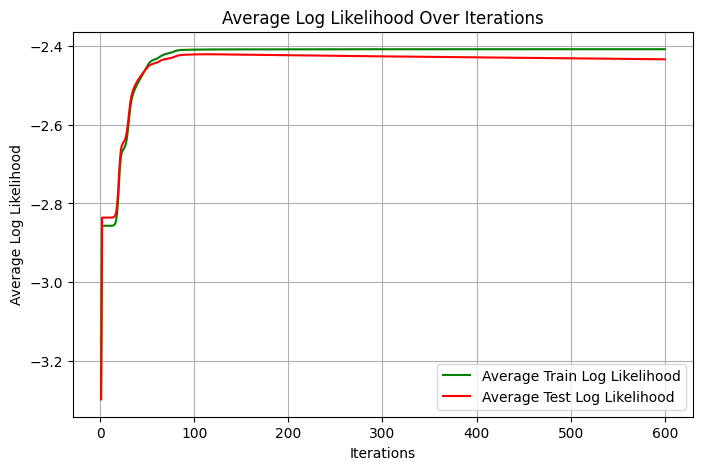

In [13]:
plt.figure(figsize=(8, 5))
iterations = range(1, len(train_log_probs) + 1)
plt.plot(iterations, train_log_probs, linestyle='-', label="Average Train Log Likelihood", color='green')
plt.plot(iterations, test_log_probs, linestyle='-', label="Average Test Log Likelihood", color='red')

plt.xlabel("Iterations")
plt.ylabel("Average Log Likelihood")
plt.title("Average Log Likelihood Over Iterations")
plt.legend()
plt.grid(True)

plt.show()

In [14]:
print(f"Final Train Log-Probability: {train_log_probs[-1]}")
print(f"Final Test Log-Probability: {test_log_probs[-1]}")

Final Train Log-Probability: -2.4084603633775385
Final Test Log-Probability: -2.434047930689298


## **(2C)**
Plot emission probabilities of a few particular letters

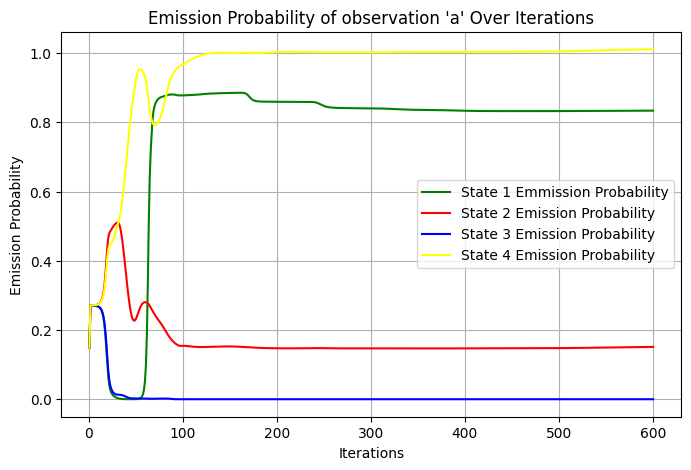

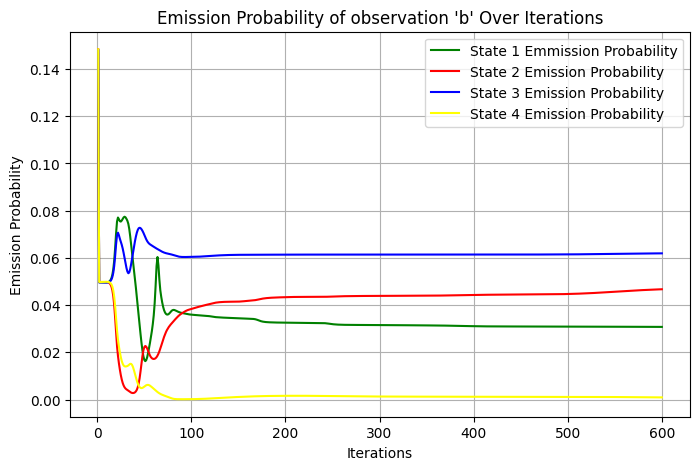

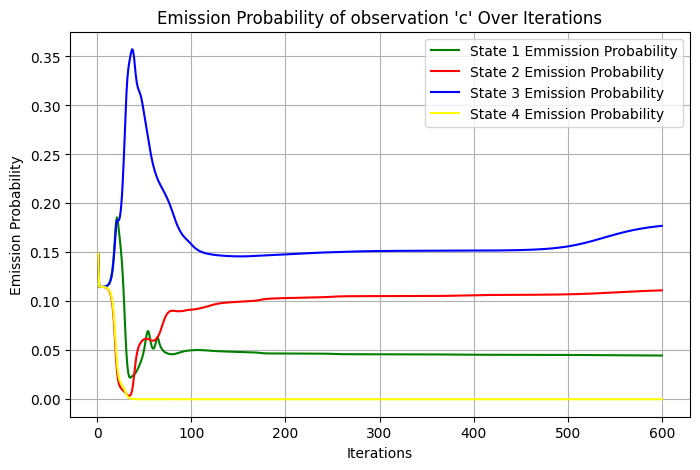

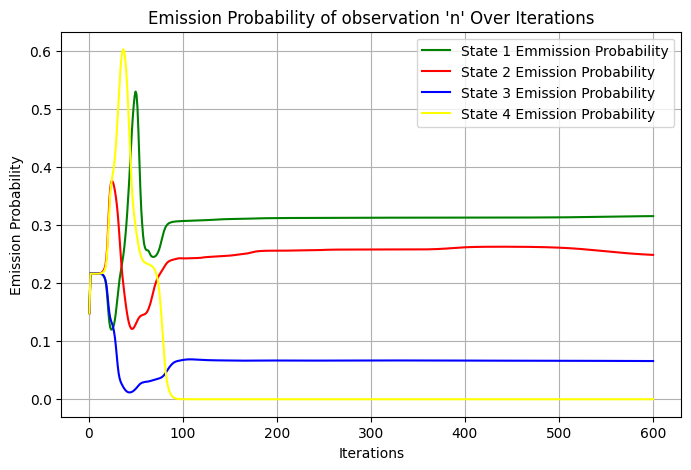

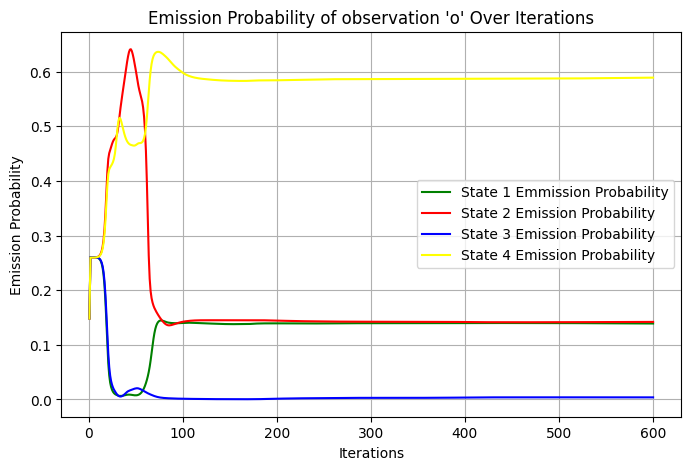

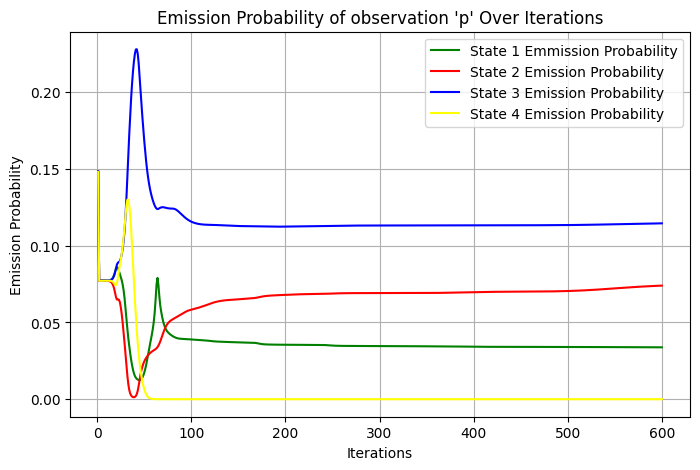

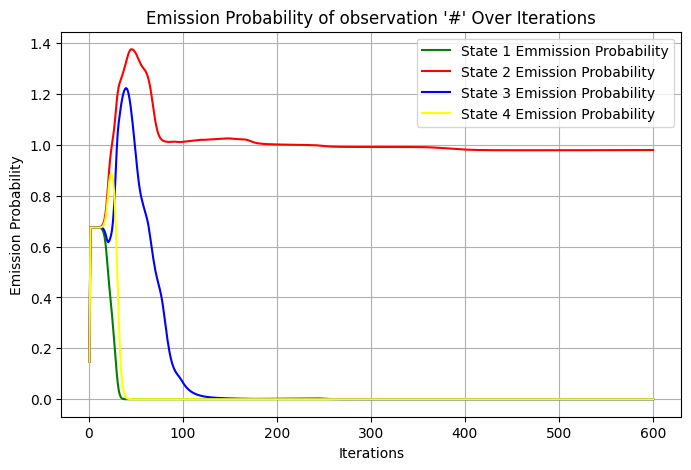

In [15]:
for k, v in letters_emission.items():
    plt.figure(figsize=(8, 5))

    iterations = range(1, len(v) + 1)
    temp = np.sum(v, axis=1)
    emission1 = np.reshape(temp[:, 0], -1)
    emission2 = np.reshape(temp[:, 1], -1)
    emission3 = np.reshape(temp[:, 2], -1)
    emission4 = np.reshape(temp[:, 3], -1)
    
    letter = 35 if k == 26 else k + 97
    plt.xlabel("Iterations")
    plt.ylabel("Emission Probability")
    plt.title(f"Emission Probability of observation \'{chr(letter)}\' Over Iterations")
    plt.plot(iterations, emission1, linestyle='-', label="State 1 Emmission Probability", color='green')
    plt.plot(iterations, emission2, linestyle='-', label="State 2 Emission Probability", color='red')
    plt.plot(iterations, emission3, linestyle='-', label="State 3 Emission Probability", color='blue')
    plt.plot(iterations, emission4, linestyle='-', label="State 4 Emission Probability", color='yellow')
    plt.legend()
    plt.grid(True)
    plt.show()

## **(2D)**
Plot and analyze emission probability distributions of each state

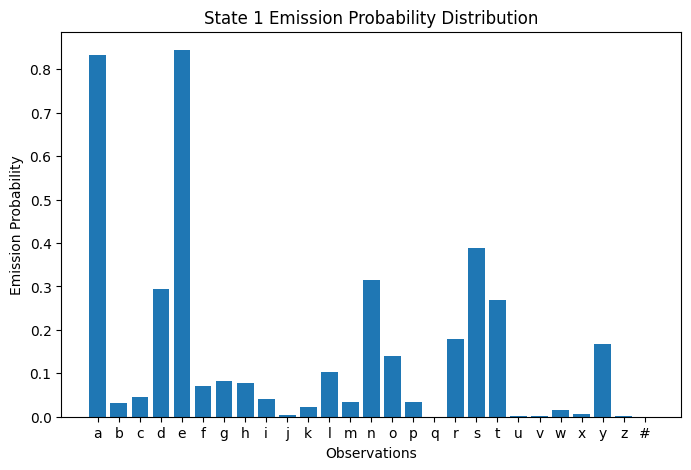

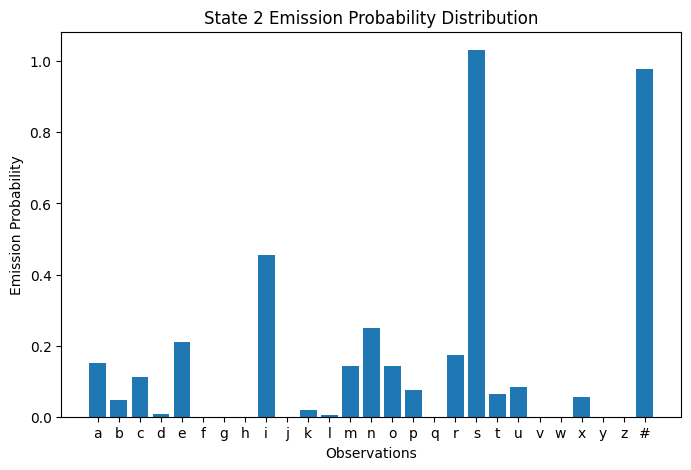

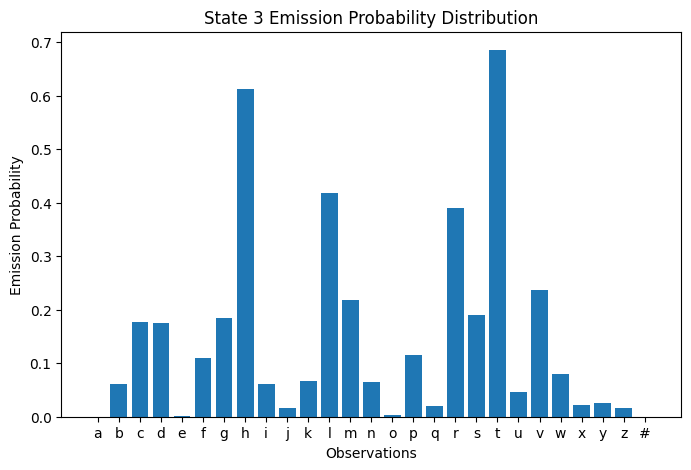

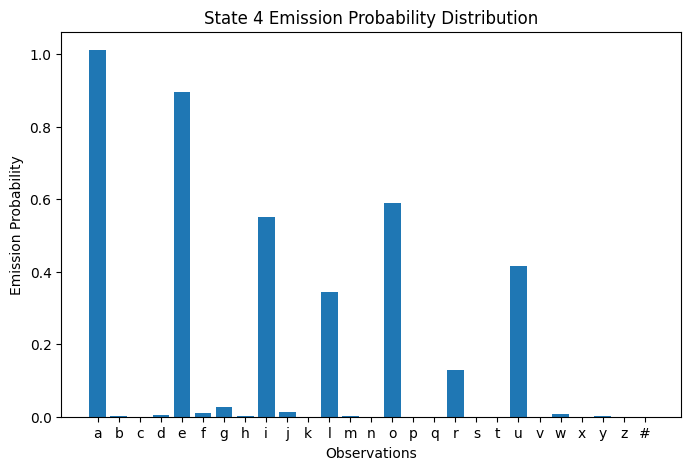

In [16]:
temp = np.sum(B, axis=1)

emission1 = np.reshape(temp[:, 0], -1)
emission2 = np.reshape(temp[:, 1], -1)
emission3 = np.reshape(temp[:, 2], -1)
emission4 = np.reshape(temp[:, 3], -1)
vocab = [chr(35) if k == 26 else chr(k + 97) for k in range(len(emission1))]

plt.figure(figsize=(8, 5))
plt.bar(vocab, emission1)
plt.xlabel("Observations")
plt.ylabel("Emission Probability")
plt.title("State 1 Emission Probability Distribution")
plt.show()

plt.figure(figsize=(8, 5))
plt.bar(vocab, emission2)
plt.xlabel("Observations")
plt.ylabel("Emission Probability")
plt.title("State 2 Emission Probability Distribution")
plt.show()

plt.figure(figsize=(8, 5))
plt.bar(vocab, emission3)
plt.xlabel("Observations")
plt.ylabel("Emission Probability")
plt.title("State 3 Emission Probability Distribution")
plt.show()

plt.figure(figsize=(8, 5))
plt.bar(vocab, emission4)
plt.xlabel("Observations")
plt.ylabel("Emission Probability")
plt.title("State 4 Emission Probability Distribution")
plt.show()


Analyze Updated Transition Matrix

In [17]:
print(A)

[[0.23817967 0.65186494 0.08268069 0.0272747 ]
 [0.03083479 0.03356423 0.68957601 0.24602497]
 [0.22514066 0.16062837 0.16631215 0.44791882]
 [0.63951646 0.12265353 0.11951654 0.11831346]]


From the plots above, similar to the 2 state HMM, the 4 state HMM seems to have learned similar structures and patterns of the English language. However, the distinctions are more clear in the 4 state HMM. For example, the state 4 has high emission probabilities for only the vowels in the English language. This shows that the model has learned some sort of pattern between vowels and consonants in the English language. The emission probability that has the most difference between the 4 states is the '#' observation (space character). From the plots, we can see that the entire emission probability is associated with state 2. So, the model has learned about the structure of the English language and how words are separated. 

From the updated transition matrix, we can see that the model once again prefers not to stay in a single state. To be more specific, it seems like the model likes to move from one state to the next state. For example, we can see that the highest transition probabilities from each state is to the next state: state 1 -> state 2, state 2 -> state 3, state 3 -> state 4, state 4 -> state 1. This general state pattern can also be used to describe the English language where after a space, the next word will likely start with a consonant (state 3 emission probabilities). Then, a vowel follows next (state 4). Followed by either 'a', 'e', or another consonant (state 1). This general pattern continues for the rest of the word. So, it is clear that the model was able to learn about the patterns in the English text.

## **(3A) (3B) (3C)**
Alternative Initialization Experiment

In [18]:
unique, counts = np.unique(train, return_counts=True)
freq = counts / np.sum(counts)
random_vector = np.random.rand(len(counts))
mean = np.mean(random_vector)
perturbation = random_vector - mean

l = 0.001
state1 = freq - l * perturbation
state2 = freq + l * perturbation

assert all(i > 0 for i in state1)
assert all(i > 0 for i in state2)

In [19]:
A = np.array([[0.49, 0.51], 
                    [0.51, 0.49]])
B = np.zeros((27, 2, 2))
B[0:13] = np.array([[0.0370, 0.0371],
                [0.0370, 0.0371]])
B[13:26] = np.array([[0.0371, 0.0370],
                    [0.0371, 0.0370]])
B[26] = np.array([[0.0367, 0.0367],
                [0.0367, 0.0367]])
B[:, 0, 0] = state1
B[:, 1, 0] = state1
B[:, 0, 1] = state2
B[:, 1, 1] = state2

assert np.sum(B) == A.shape[0] * A.shape[1]

In [20]:
A, B, train_log_probs, test_log_probs, letters_emission = baum_welch(A, B, train, test, [], 600)
assert all(x <= y for x, y in zip(train_log_probs, train_log_probs[1:]))

100%|██████████| 600/600 [02:55<00:00,  3.42it/s]


Plot average log-probabilities of train and test data

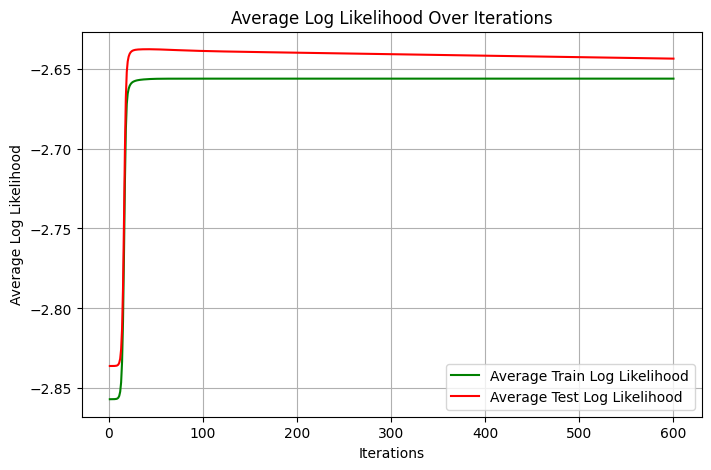

In [21]:
plt.figure(figsize=(8, 5))
iterations = range(1, len(train_log_probs) + 1)
plt.plot(iterations, train_log_probs, linestyle='-', label="Average Train Log Likelihood", color='green')
plt.plot(iterations, test_log_probs, linestyle='-', label="Average Test Log Likelihood", color='red')

plt.xlabel("Iterations")
plt.ylabel("Average Log Likelihood")
plt.title("Average Log Likelihood Over Iterations")
plt.legend()
plt.grid(True)

plt.show()

In [22]:
print(f"Final Train Log-Probability: {train_log_probs[-1]}")
print(f"Final Test Log-Probability: {test_log_probs[-1]}")

Final Train Log-Probability: -2.6563077826112953
Final Test Log-Probability: -2.6437965200520375


From (1d), the final average train log-prob was -2.6563159566542938 and the final avergae test log-prob was -2.6462074084741056. These are very, very close to the final average log-probs when using the alternate initialization HMM. Additionally, from the two plots (see 1b), the two average log-probs over iterations are very similar and seem to converge to the same value. However, it seems like the initial average log-probs were higher for the alternative initialization method. Lastly, it seems like it took both HMMs the same amount of iterations to converge.